### Creating graphs with age

In [19]:
import pandas as pd
import os

In [31]:
NOTEBOOK_DIR = os.getcwd()
DATA_DIR = os.path.join(NOTEBOOK_DIR, "..", "data")
CHECKPOINTS_DIR = os.path.join(DATA_DIR, "checkpoints")
DATA_PATH = os.path.join(CHECKPOINTS_DIR, "checkpoint12_age.csv")

OUT_DIR = os.path.join(DATA_DIR, "Figures")
os.makedirs(DATA_DIR, exist_ok=True)


In [21]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [22]:
TARGET_CATS = [
    "Drug and Substance Use",
    "Domestic Disputes and Protection",
    "Violent and Weapon Offenses",
]

In [23]:
df = pd.read_csv(DATA_PATH)

In [24]:
# standardize expected columns
needed = {"Year", "Age", "category", "person_id"}
missing = needed - set(df.columns)
if missing:
    raise ValueError(f"Missing columns: {missing}")

In [25]:
# coerce types
df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype("Int64")
df["Age"] = pd.to_numeric(df["Age"], errors="coerce")
df = df.dropna(subset=["Year", "Age", "category"])

In [ ]:
# # optional filter, adjust if your data needs a wider window
# df = df[(df["Age"] >= 10) & (df["Age"] <= 90)]

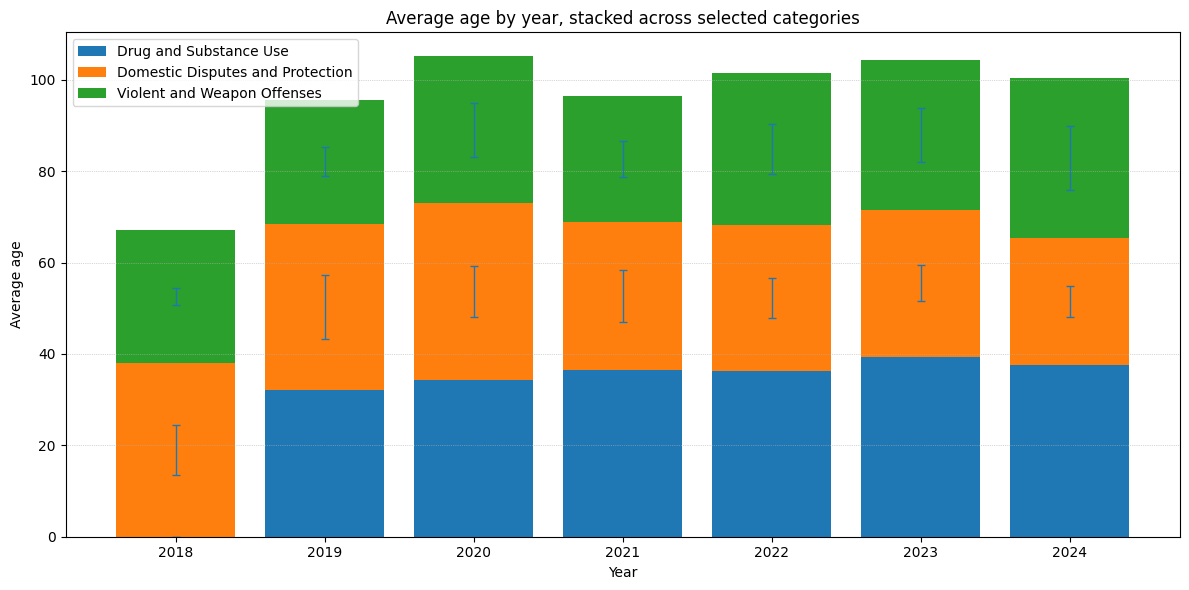

In [33]:
# ---------- 1) stacked bar: mean age per year for three categories, with std dev as error bars ----------
def plot_stacked_mean_age(df, cats, outfile):
    # compute mean and std by year and category
    grp = df[df["category"].isin(cats)].groupby(["Year", "category"])["Age"]
    stats = grp.agg(mean="mean", std="std").reset_index()

    years = sorted(stats["Year"].unique())
    # build arrays aligned by year for each category
    mean_by_cat = {c: [0.0] * len(years) for c in cats}
    std_by_cat = {c: [0.0] * len(years) for c in cats}

    year_idx = {y: i for i, y in enumerate(years)}
    for _, row in stats.iterrows():
        i = year_idx[row["Year"]]
        c = row["category"]
        mean_by_cat[c][i] = row["mean"]
        std_by_cat[c][i] = 0.0 if pd.isna(row["std"]) else row["std"]

    x = np.arange(len(years))
    fig = plt.figure(figsize=(12, 6))
    bottom = np.zeros(len(years))

    # draw stacks
    bar_centers = []  # center y of each segment, used for error bars
    for c in cats:
        heights = np.array(mean_by_cat[c])
        bars = plt.bar(x, heights, bottom=bottom, label=c)
        # store center of each stacked segment
        centers = bottom + heights / 2.0
        bar_centers.append((c, centers))
        bottom = bottom + heights  # update stack

    # add error bars for each segment using its own std
    # error bars do not stack mathematically, they reflect the spread in that segment
    # we place each error bar at the vertical center of its segment
    for cat_name, centers in bar_centers:
        errs = np.array(std_by_cat[cat_name])
        # small jitter for visibility when std is zero
        errs = np.where(np.isnan(errs), 0.0, errs)
        plt.errorbar(x, centers, yerr=errs / 2.0, fmt="none", capsize=3, linewidth=1)

    plt.xticks(x, years, rotation=0)
    plt.xlabel("Year")
    plt.ylabel("Average age")
    plt.title("Average age by year, stacked across selected categories")
    plt.legend()
    plt.grid(True, axis="y", linestyle=":", linewidth=0.5)
    plt.tight_layout()
    plt.savefig(outfile, dpi=150)
    plt.show()
    plt.close()

plot_stacked_mean_age(df, TARGET_CATS, os.path.join(OUT_DIR, "age_stacked_mean_by_year.png"))

### Check stacked bar graph data

In [37]:
import numpy as np
import pandas as pd

def inspect_stacked_mean_age(df, cats):
    """
    Print all relevant data and stats used by plot_stacked_mean_age.
    This mirrors the logic in your plotting code so you can verify every value.
    """
    print("\n=== 0) Filter and group ===")
    sub = df[df["category"].isin(cats)].copy()
    grp = sub.groupby(["Year", "category"])["Age"]
    stats = grp.agg(n="count", mean="mean", std="std").reset_index()
    stats = stats.sort_values(["Year", "category"]).reset_index(drop=True)
    print(stats.to_string(index=False))

    print("\n=== 1) Year order used in the plot ===")
    years = sorted(stats["Year"].unique())
    print("years:", years)

    print("\n=== 2) Pivot tables, one row per Year ===")
    mean_piv = stats.pivot(index="Year", columns="category", values="mean").reindex(years)
    std_piv  = stats.pivot(index="Year", columns="category", values="std").reindex(years)
    n_piv    = stats.pivot(index="Year", columns="category", values="n").reindex(years)

    print("\n-- mean by Year x category --")
    print(mean_piv.fillna(0).round(4).to_string())
    print("\n-- std by Year x category --")
    print(std_piv.fillna(0).round(4).to_string())
    print("\n-- count by Year x category --")
    print(n_piv.fillna(0).astype(int).to_string())

    print("\n=== 3) Arrays actually used by the plotting code ===")
    mean_by_cat = {c: [0.0] * len(years) for c in cats}
    std_by_cat  = {c: [0.0] * len(years) for c in cats}
    year_idx = {y: i for i, y in enumerate(years)}

    # fill from stats, identical to your loop
    for _, row in stats.iterrows():
        i = year_idx[row["Year"]]
        c = row["category"]
        mean_by_cat[c][i] = float(row["mean"])
        std_by_cat[c][i]  = 0.0 if pd.isna(row["std"]) else float(row["std"])

    print("mean_by_cat:")
    for c in cats:
        print(f"  {c}: {np.array(mean_by_cat[c]).round(4)}")
    print("std_by_cat:")
    for c in cats:
        print(f"  {c}: {np.array(std_by_cat[c]).round(4)}")

    print("\n=== 4) Per year totals of the stack heights, sum of means across cats ===")
    total_stack = np.zeros(len(years))
    for c in cats:
        total_stack += np.array(mean_by_cat[c], dtype=float)
    print("total_stack_by_year:", np.round(total_stack, 4))

    print("\n=== 5) Bottoms, centers, and tops for each stacked segment ===")
    bottom = np.zeros(len(years))
    seg_rows = []
    for c in cats:
        heights = np.array(mean_by_cat[c], dtype=float)
        centers = bottom + heights / 2.0
        tops = bottom + heights
        seg_rows.append(
            pd.DataFrame({
                "category": c,
                "Year": years,
                "bottom_before": np.round(bottom, 4),
                "height_mean": np.round(heights, 4),
                "center_for_err": np.round(centers, 4),
                "top_after": np.round(tops, 4),
                "std_for_err": np.round(np.array(std_by_cat[c], dtype=float), 4),
                "yerr_plotted": np.round(np.array(std_by_cat[c], dtype=float) / 2.0, 4)
            })
        )
        bottom = tops  # update for next segment

    seg_table = pd.concat(seg_rows, ignore_index=True)
    # nice ordering
    seg_table = seg_table[[
        "Year", "category", "bottom_before", "height_mean",
        "center_for_err", "std_for_err", "yerr_plotted", "top_after"
    ]]
    print(seg_table.to_string(index=False))

    print("\n=== 6) Sanity checks ===")
    # A) top of last segment equals the total stack for each year
    last_tops = seg_table[seg_table["category"] == cats[-1]].set_index("Year")["top_after"].reindex(years).values
    ok_total_match = np.allclose(last_tops, total_stack, equal_nan=True)
    print(f"A) last segment top equals total stack per year: {ok_total_match}")
    if not ok_total_match:
        print("   expected:", np.round(total_stack, 6))
        print("   got     :", np.round(last_tops, 6))

    # B) no negative heights
    any_neg_heights = (seg_table["height_mean"] < 0).any()
    print(f"B) any negative heights: {bool(any_neg_heights)}")

    # C) error bar centers lie between bottom and top
    within_bounds = (
        (seg_table["center_for_err"] >= seg_table["bottom_before"]) &
        (seg_table["center_for_err"] <= seg_table["top_after"])
    ).all()
    print(f"C) centers within their segment bounds: {bool(within_bounds)}")

    # D) counts present for all category, year pairs used
    missing_pairs = []
    for y in years:
        for c in cats:
            if pd.isna(mean_piv.loc[y, c]) if c in mean_piv.columns else True:
                missing_pairs.append((y, c))
    if missing_pairs:
        print("D) missing Year, category pairs found, these will appear as zeros in the bar:")
        print(missing_pairs)
    else:
        print("D) no missing Year, category pairs")

    print("\n=== 7) Quick per year summary ===")
    # build a simple summary line per year
    for i, y in enumerate(years):
        parts = []
        cum = 0.0
        for c in cats:
            h = float(mean_by_cat[c][i])
            s = float(std_by_cat[c][i])
            parts.append(f"{c}: mean={h:.4f}, std={s:.4f}")
            cum += h
        print(f"Year {y}: total={cum:.4f} | " + " | ".join(parts))

    return {
        "years": years,
        "stats_long": stats,
        "mean_pivot": mean_piv,
        "std_pivot": std_piv,
        "count_pivot": n_piv,
        "mean_by_cat": mean_by_cat,
        "std_by_cat": std_by_cat,
        "segment_table": seg_table,
        "total_stack_by_year": total_stack,
    }

# usage:
debug = inspect_stacked_mean_age(df, TARGET_CATS)



=== 0) Filter and group ===
 Year                         category   n      mean       std
 2018 Domestic Disputes and Protection   3 38.000000 11.000000
 2018      Violent and Weapon Offenses   5 29.200000  3.563706
 2019 Domestic Disputes and Protection  18 36.444444 13.984118
 2019           Drug and Substance Use  65 32.076923  9.004006
 2019      Violent and Weapon Offenses  27 27.074074  6.396669
 2020 Domestic Disputes and Protection  10 38.600000 10.986861
 2020           Drug and Substance Use 258 34.368217  9.805505
 2020      Violent and Weapon Offenses  39 32.179487 11.949173
 2021 Domestic Disputes and Protection  25 32.400000 11.265730
 2021           Drug and Substance Use 268 36.503731 10.194181
 2021      Violent and Weapon Offenses  55 27.581818  7.908483
 2022 Domestic Disputes and Protection  20 32.100000  8.890563
 2022           Drug and Substance Use 147 36.183673 10.179230
 2022      Violent and Weapon Offenses  40 33.275000 10.998805
 2023 Domestic Disputes an

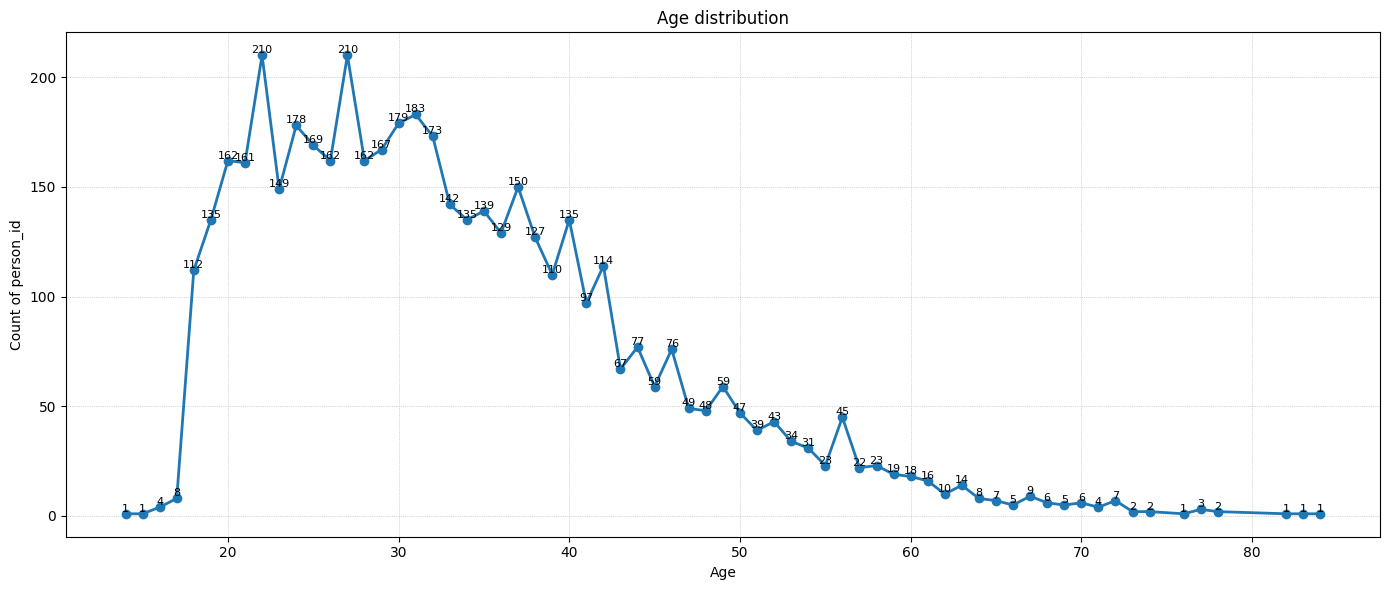

In [34]:
# ---------- 2) age distribution, line of counts by exact age with point labels ----------
def plot_age_distribution(df, outfile, annotate_threshold=0):
    # count people by age, prefer counting unique person_id if present
    if "person_id" in df.columns:
        counts = df.groupby("Age")["person_id"].nunique().astype(int)
    else:
        counts = df.groupby("Age").size().astype(int)

    ages = counts.index.astype(int).tolist()
    vals = counts.values.tolist()

    fig = plt.figure(figsize=(14, 6))
    plt.plot(ages, vals, marker="o", linewidth=2)

    # annotate each point, you can raise annotate_threshold to reduce clutter
    for a, v in zip(ages, vals):
        if v >= annotate_threshold:
            plt.text(a, v, f"{v}", ha="center", va="bottom", fontsize=8)

    plt.xlabel("Age")
    plt.ylabel("Count of person_id")
    plt.title("Age distribution")
    plt.grid(True, linestyle=":", linewidth=0.5)
    plt.tight_layout()
    plt.savefig(outfile, dpi=150)
    plt.show()
    plt.close()

plot_age_distribution(df, os.path.join(OUT_DIR, "age_distribution.png"), annotate_threshold=0)

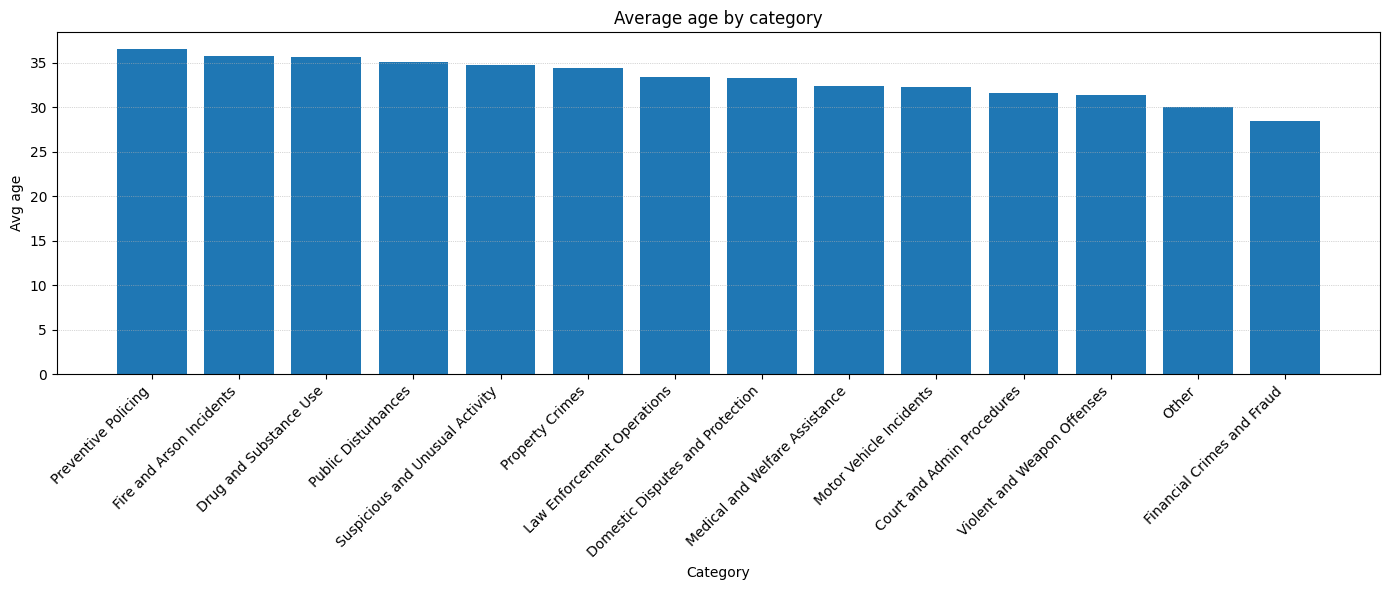

In [35]:
# ---------- 3) average age by category, bar chart ----------
def plot_avg_age_by_category(df, outfile, min_count=10):
    # compute mean age by category, show only categories with enough rows
    agg = df.groupby("category").agg(
        avg_age=("Age", "mean"),
        n=("Age", "size")
    ).reset_index()
    agg = agg[agg["n"] >= min_count].sort_values("avg_age", ascending=False)

    fig = plt.figure(figsize=(14, 6))
    x = np.arange(len(agg))
    plt.bar(x, agg["avg_age"].values)
    plt.xticks(x, agg["category"].values, rotation=45, ha="right")
    plt.xlabel("Category")
    plt.ylabel("Avg age")
    plt.title("Average age by category")
    plt.grid(True, axis="y", linestyle=":", linewidth=0.5)
    plt.tight_layout()
    plt.savefig(outfile, dpi=150)
    plt.show()
    plt.close()

plot_avg_age_by_category(df, os.path.join(OUT_DIR, "avg_age_by_category.png"), min_count=5)